## Fairness Coursework.

Install the library and download the dataset.

In [1]:
!pip install 'aif360[LFR]'

In [2]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data

--2022-02-15 17:22:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.2’

adult.data.2        100%[===================>]   3.79M  6.83MB/s    in 0.6s    

2022-02-15 17:22:33 (6.83 MB/s) - ‘adult.data.2’ saved [3974305/3974305]

--2022-02-15 17:22:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names.2’

adult.names.2       100%[===================>]   5.11K  --.-KB/s    in 0s      


In [4]:
!pip install fairlearn

## Import Libraries

In [5]:
#STEP 1: Import the libraries and set the random seed.

import numpy as np


from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german

from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

import pdb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import *

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import random

np.random.seed(0)

## Preprocess Data

In [6]:
#STEP 2: We define where's the bias in the features of our dataset.
use_adult_dataset = True
privileged_groups = [{'sex': 1}] # Male
unprivileged_groups = [{'sex': 0}] # Female
if use_adult_dataset:
    dataset_orig = load_preproc_data_adult(['sex'])
else:
    dataset_orig = load_preproc_data_german(['sex'])

#STEP 3: We split between training and test set.
train, test = dataset_orig.split([0.7], shuffle=True)
print(train.feature_names)

# print("training data size", train.features.shape)
print("dataset feature names", train.feature_names)

#Normalize the dataset, both train and test. This should always be done in any machine learning pipeline!
scale_orig = StandardScaler()

X_train = scale_orig.fit_transform(train.features)
y_train = train.labels.ravel()

X_test = scale_orig.transform(test.features)
y_test = test.labels.ravel()

print(X_train.shape)
print(y_train.shape)

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
(34189, 18)
(34189,)


## Functions

In [7]:

def get_fairness_metrics(metric):
    metric_arrs = {}
    metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
    metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
    metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
    metric_arrs['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
    metric_arrs['disp_imp']=(metric.disparate_impact())
    return metric_arrs


def k_folds_on_train(train, X_train, y_train, folds=5, weights=None, C=1.0, print_k=True):
    random_number = random.randint(1, 10)   
    kf = KFold(n_splits=folds, random_state=10, shuffle=True)
    accuracies = []
    fairnesses = []

    k = 1
    for train_index, val_index in kf.split(X_train):
        if print_k:
            print("k:", k)
        val = train.subset(val_index)
        train_k = train.subset(train_index)

        X_train_k, X_val = X_train[train_index], X_train[val_index]
        y_train_k, y_val = y_train[train_index], y_train[val_index]

        # random_number = random.randint(1, 10)
        model = LogisticRegression(solver='liblinear', penalty="l2", random_state=1, C=C)  #(C=reg_best, solver='liblinear', random_state=1) 

        if weights is not None:
            # print("subgroup weights", np.unique(train.instance_weights))
            training_weights = weights[train_index]
            model.fit(X_train_k, y_train_k, sample_weight=training_weights)
        else:
            model.fit(X_train_k, y_train_k)

        accuracy, eq_op_diff = evaluate(model, val, X_val, y_val)
        accuracies.append(accuracy)
        fairnesses.append(eq_op_diff)

        if print_k:
            print("Accuracy", accuracy) 
            print("Equality of Opportunity", eq_op_diff) 

        k += 1

    accuracy_mean = np.mean(accuracies)
    fairness_mean = np.mean(fairnesses)

    accuracy_std = np.std(accuracies)
    fairness_std = np.std(fairnesses)

    return accuracy_mean, fairness_mean, accuracy_std, fairness_std


def evaluate(model, test_dataset, X_test, y_test):
    predictions = model.predict(X_test)

    if not use_adult_dataset:
        predictions = abs(predictions-2) 
        y_test = abs(y_test-2)
        
    test_pred = test_dataset.copy()
    test_pred.labels = predictions

    accuracy = sum(predictions==y_test)/len(y_test)

    metric = ClassificationMetric(test_dataset, test_pred, unprivileged_groups=[{'sex': 0}], privileged_groups=[{'sex': 1}])
    metric_arrs = get_fairness_metrics(metric)
    eq_op_diff = -(np.abs(metric_arrs['eq_opp_diff']))

    return accuracy, eq_op_diff 


def plot(C_array, acc_array, fair_array):
    y1 = np.array(acc_array)[:, 0]
    std1 = np.array(acc_array)[:, 1]

    y2 = np.array(fair_array)[:, 0]
    std2 = np.array(fair_array)[:, 1]

    fig,ax = plt.subplots()
    ax.set_xscale('log')
    ax.plot(C_array, y1, color="red", marker="")
    ax.fill_between(C_array, y1 - std1, y1 + std1, alpha=0.2, color="red")
    ax.set_xlabel("C",fontsize=14)
    ax.set_ylabel("Accuracy",color="red",fontsize=14)

    ax2=ax.twinx()
    ax2.plot(C_array, y2, color="blue", marker="")
    ax2.fill_between(C_array, y2 - std2, y2 + std2, alpha=0.2, color="blue")
    ax2.set_ylabel("Equality of Opportunity",color="blue",fontsize=14)


In [8]:
def hyperparameter_tuning(C_array, 
                          train, 
                          X_train, 
                          y_train, 
                          folds, 
                          weights, 
                          test, 
                          X_test, 
                          y_test, 
                          print_C=False):
    
    acc_array = []
    fair_array = []
    crit_array = []
    best_accuracy_model = None
    best_fair_model = None
    best_crit_model = None
    
    for C_reg in C_array:
        
        accuracy_cv, fairness_cv, \
        accuracy_std, fairness_std = k_folds_on_train(train, 
                                                      X_train, 
                                                      y_train, 
                                                      folds=5, 
                                                      weights=weights, 
                                                      C=C_reg, 
                                                      print_k=False
                                                      )
        
        model = LogisticRegression(solver='liblinear', penalty="l2", random_state=10, C=C_reg)

        if weights is not None:
            # print("subgroup weights", np.unique(train.instance_weights))
            training_weights = weights
            model.fit(X_train, y_train, sample_weight=training_weights)
        else:
            model.fit(X_train, y_train)


        accuracy, eq_op_diff = evaluate(model, test, X_test, y_test)

        acc_array.append([accuracy_cv, accuracy_std])
        fair_array.append([fairness_cv, fairness_std])
        
        beta = 1 # fairness considered beta times as important as accuracy
        criterion = (1 + beta**2) * (accuracy * (1 - abs(eq_op_diff))) / ((beta**2 * accuracy) + (1 - abs(eq_op_diff)))
        crit_array.append(criterion)

        if print_C:
            print("\nC value = ", C_reg)
            print("Test Accuracy", accuracy) 
            print("Test Equality of Opportunity", eq_op_diff) 
            print("Train Accuracy", accuracy_cv) 
            print("Train Equality of Opportunity", fairness_cv) 
            print("Criterion", criterion) 

        model_features = (model, criterion, accuracy, eq_op_diff, C_reg)
        
        if best_accuracy_model == None:
            best_accuracy_model = model_features
            best_fair_model = model_features
            best_crit_model = model_features
        else:
            if accuracy > best_accuracy_model[2]:
                best_accuracy_model = model_features
            if abs(eq_op_diff) < abs(best_fair_model[3]):
                best_fair_model = model_features
            if criterion > best_crit_model[1]:
                best_crit_model = model_features


    return best_accuracy_model, best_fair_model, best_crit_model, acc_array, fair_array, crit_array

## PART 1 - UNWEIGHTED

PART 1 - UNWEIGHTED

BEST ACCURACY MODEL (1): 
[test accuracy: 0.8050228622125162] 
[test equal opportunity: -0.4356902356902357]
[C: 0.001]
BEST FAIRNESS MODEL (2): 
[test accuracy: 0.7975841124684365] 
[test equal opportunity: -0.2189742958035641]
[C: 1e-05]


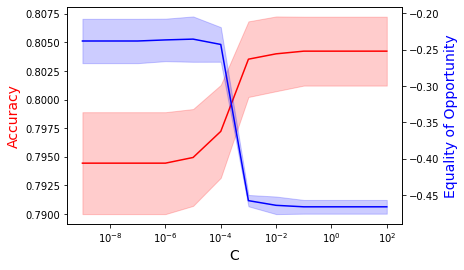

In [15]:
#PART 1 - UNWEIGHTED
C_array = np.logspace(-9,2,12)
print("PART 1 - UNWEIGHTED")
best_accuracy_model, best_fair_model, \
best_crit_model, acc_array, fair_array, _ = hyperparameter_tuning(C_array, 
                                                               train, 
                                                               X_train, 
                                                               y_train, 
                                                               5, 
                                                               None, 
                                                               test,
                                                               X_test, 
                                                               y_test)

test_accuracy_BA, test_fairness_BA = evaluate(best_accuracy_model[0], test, X_test, y_test)
test_accuracy_BF, test_fairness_BF = evaluate(best_fair_model[0], test, X_test, y_test)

print(f"\nBEST ACCURACY MODEL (1): \n[test accuracy: {test_accuracy_BA}] \n"
f"[test equal opportunity: {test_fairness_BA}]\n"
f"[C: {best_accuracy_model[-1]}]")

print(f"BEST FAIRNESS MODEL (2): \n[test accuracy: {test_accuracy_BF}] \n"
f"[test equal opportunity: {test_fairness_BF}]\n"
f"[C: {best_fair_model[-1]}]")

# print(f" $Accuracy$ & {round(test_accuracy_BA, 3)} & {round(test_accuracy_BF, 3)}\\ \n"
# f" $EOD$ & {round(test_fairness_BA, 3)} & {round(test_fairness_BF, 3)}\\ \n"
# f" $C$ & {best_accuracy_model[-1]} & {best_fair_model[-1]}\\")

plot(C_array, acc_array, fair_array)

## PART 2 - REWEIGHED

PART 2 - REWEIGHED

BEST ACCURACY MODEL (1): 
[test accuracy: 0.7905548351873336] 
[test equal opportunity: -0.03513180586351322] 
[C: 0.0001]
BEST FAIRNESS MODEL (2): 
[test accuracy: 0.7876202825359995] 
[test equal opportunity: -0.03327174180832715] 
[C: 1e-09]


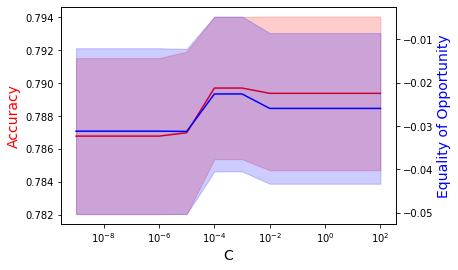

In [16]:
#PART 2 - REWEIGHED
print("PART 2 - REWEIGHED")
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)
train = RW.fit_transform(train)
weights=train.instance_weights

best_accuracy_model, best_fair_model, \
best_crit_model, acc_array, fair_array, _ = hyperparameter_tuning(C_array, 
                                                                    train, 
                                                                    X_train, 
                                                                    y_train, 
                                                                    5, 
                                                                    weights, 
                                                                    test,
                                                                    X_test, 
                                                                    y_test,
                                                                    print_C=False)

test_accuracy_BA, test_fairness_BA = evaluate(best_accuracy_model[0], test, X_test, y_test)
test_accuracy_BF, test_fairness_BF = evaluate(best_fair_model[0], test, X_test, y_test)

print(f"\nBEST ACCURACY MODEL (1): \n[test accuracy: {test_accuracy_BA}] \n"
f"[test equal opportunity: {test_fairness_BA}] \n"
f"[C: {best_accuracy_model[-1]}]")

print(f"BEST FAIRNESS MODEL (2): \n[test accuracy: {test_accuracy_BF}] \n"
f"[test equal opportunity: {test_fairness_BF}] \n"
f"[C: {best_fair_model[-1]}]")

# print(f" $Accuracy$ & {round(test_accuracy_BA, 3)} & {round(test_accuracy_BF, 3)}\\ \n"
# f" $EOD$ & {round(test_fairness_BA, 3)} & {round(test_fairness_BF, 3)}\\ \n"
# f" $C$ & {best_accuracy_model[-1]} & {best_fair_model[-1]}\\")

plot(C_array, acc_array, fair_array)



## PART 3 - CHOOSE BASED ON CRITERION

In [17]:
# UNWEIGHED
print("UNWEIGHED - CRITERION EVALUATION")
best_accuracy_model, best_fair_model, \
best_crit_model, acc_array, fair_array, crit_array = hyperparameter_tuning(C_array, 
                                                                        train, 
                                                                        X_train, 
                                                                        y_train, 
                                                                        5, 
                                                                        None, 
                                                                        test,
                                                                        X_test, 
                                                                        y_test,
                                                                        print_C=False)

test_accuracy_BC, test_fairness_BC = evaluate(best_crit_model[0], test, X_test, y_test)

print(f"BEST CRITERION MODEL (5): \n[test accuracy: {test_accuracy_BC}] \n"
f"[test equal opportunity: {test_fairness_BC}]")
print(f"[criterion: {best_crit_model[1]}]\n"
f"[C: {best_crit_model[-1]}]\n"
f"[F: {best_crit_model[1]}]")

print("\nREWEIGHED - HYPERPARAMETER VARIATION")
# REWEIGHED
best_accuracy_model, best_fair_model, \
best_crit_model_RW, acc_array, fair_array, crit_array = hyperparameter_tuning(C_array, 
                                                               train, 
                                                               X_train, 
                                                               y_train, 
                                                               5, 
                                                               weights, 
                                                               test,
                                                               X_test, 
                                                               y_test,
                                                               print_C=False)

test_accuracy_BC_RW, test_fairness_BC_RW = evaluate(best_crit_model_RW[0], test, X_test, y_test)

print(f"BEST CRITERION MODEL (6): \n[test accuracy: {test_accuracy_BC_RW}] \n"
f"[test equal opportunity: {test_fairness_BC_RW}]")
print(f"[criterion: {best_crit_model_RW[1]}]\n"
f"[C: {best_crit_model_RW[-1]}]\n"
f"[F: {best_crit_model_RW[1]}]")

# print(f" $Accuracy$ & {round(test_accuracy_BC, 3)} & {round(test_accuracy_BC_RW, 3)}\\ \n"
# f" $EOD$ & {round(test_fairness_BC, 3)} & {round(test_fairness_BC_RW, 3)}\\ \n"
# f" $C$ & {best_crit_model[-1]} & {best_crit_model_RW[-1]}\\ \n"
# f" $F$ & {round(best_crit_model[1], 3)} & {round(best_crit_model_RW[1],3)}\\")


UNWEIGHED - CRITERION EVALUATION
BEST CRITERION MODEL (5): 
[test accuracy: 0.7975841124684365] 
[test equal opportunity: -0.2189742958035641]
[criterion: 0.7892180658202437]
[C: 1e-05]
[F: 0.7892180658202437]

REWEIGHED - HYPERPARAMETER VARIATION
BEST CRITERION MODEL (6): 
[test accuracy: 0.7905548351873336] 
[test equal opportunity: -0.03513180586351322]
[criterion: 0.8690568637314617]
[C: 0.0001]
[F: 0.8690568637314617]


## PART 4 - REMOVE FEATURE (SEX)



(34189, 17)
UNWEIGHED - CRITERION EVALUATION

BEST CRITERION MODEL (5): 
[test accuracy: 0.7900088719033646] 
[test equal opportunity: -0.011328734499466198]
[criterion: 0.8782456774733607]
[C: 0.01]


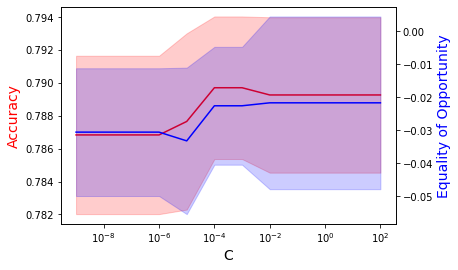

In [18]:
X_train_copy = X_train.copy()
X_train_ab = np.delete(X_train_copy, 1, 1)
X_test_copy = X_test.copy()
X_test_ab = np.delete(X_test_copy, 1, 1)
print(X_train_ab.shape)

print("UNWEIGHED - CRITERION EVALUATION")
best_accuracy_model, best_fair_model, \
best_crit_model, acc_array, fair_array, _ = hyperparameter_tuning(C_array, 
                                                               train, 
                                                               X_train_ab, 
                                                               y_train, 
                                                               5, 
                                                               None, 
                                                               test,
                                                               X_test_ab, 
                                                               y_test,
                                                               print_C=False)

test_accuracy_BC, test_fairness_BC = evaluate(best_crit_model[0], test, X_test_ab, y_test)

print(f"\nBEST CRITERION MODEL (5): \n[test accuracy: {test_accuracy_BC}] \n"
f"[test equal opportunity: {test_fairness_BC}]")
print(f"[criterion: {best_crit_model[1]}]\n"
f"[C: {best_crit_model[-1]}]")

plot(C_array, acc_array, fair_array)


REWEIGHED - HYPERPARAMETER VARIATION

BEST CRITERION MODEL (6): 
[test accuracy: 0.7905548351873336] 
[test equal opportunity: -0.03513180586351322]
[criterion: 0.8690568637314617]
[C: 0.0001]


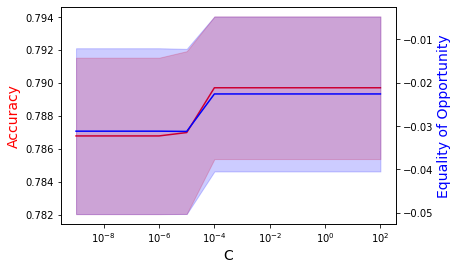

In [19]:
print("\nREWEIGHED - HYPERPARAMETER VARIATION")
# REWEIGHED
best_accuracy_model, best_fair_model, \
best_crit_model_RW, acc_array_RW, fair_array_RW, _ = hyperparameter_tuning(C_array, 
                                                                        train, 
                                                                        X_train_ab, 
                                                                        y_train, 
                                                                        5, 
                                                                        weights, 
                                                                        test,
                                                                        X_test_ab, 
                                                                        y_test,
                                                                        print_C=False)

test_accuracy_BC_RW, test_fairness_BC_RW = evaluate(best_crit_model_RW[0], test, X_test_ab, y_test)

print(f"\nBEST CRITERION MODEL (6): \n[test accuracy: {test_accuracy_BC_RW}] \n"
f"[test equal opportunity: {test_fairness_BC_RW}]")
print(f"[criterion: {best_crit_model_RW[1]}]\n"
f"[C: {best_crit_model_RW[-1]}]")

plot(C_array, acc_array_RW, fair_array_RW)

# print(f" $Accuracy$ & {round(test_accuracy_BC, 3)} & {round(test_accuracy_BC_RW, 3)}\\ \n"
# f" $EOD$ & {round(test_fairness_BC, 3)} & {round(test_fairness_BC_RW, 3)}\\ \n"
# f" $C$ & {best_crit_model[-1]} & {best_crit_model_RW[-1]}\\")